In [13]:
import pandas as pd
import numpy as np
import scipy as sp
import csv
import pickle #to save notebook at sessions
import seaborn as sns
import matplotlib.pyplot as plt
import ast
from scipy.stats import ttest_ind


#from Bojar lab format
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import LabelEncoder

#set path for pickles to be saved in
pickle_path = '/Users/erikazhang/Dropbox (MIT)/20.440 Biological Networks/project/python pickles/'

# model evaluation function
def model_evaluation(model, x, y):
#     print(f"Accuracy for 'PHA-L high' class: {100*(model.score(x[y==1], y[y==1])):>4f}%")
#     print(f"Accuracy for 'PHA-L low' class: {100*(model.score(x[y==0], y[y==0])):>4f}%")
#     print(f"Overall accuracy: {100*(model.score(x, y)):>4f}%")
    
    model_predict = model.predict(x)
    model_predict_prob = model.predict_proba(x)
    
    high = f"{100*(model.score(x[y==1], y[y==1])):>4f}%"
    low = f'{100*(model.score(x[y==0], y[y==0])):>4f}%'
    total = f'{100*(model.score(x, y)):>4f}%'
    
    loss = f'{log_loss(y, model_predict_prob):>4f}%'
    roc_auc = f'{roc_auc_score(y, model_predict):>4f}'
    f1 = f'{f1_score(y, model_predict):>4f}'
    
    return high, low, total, loss, roc_auc, f1

# Defining key parameters and functions

In [132]:
# Parameters for grid search

# Number of trees in random forest
n_estimators = [int(x) for x in np.arange(200, 800, step=100)]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.arange(10, 50, step=10)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2,5]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               }

In [133]:
'''
Generate training, validation, and test set from original full df using scikit learn 
saves best estimator model as a pickle

Input: 
- dictionary: dictionary containing the three split subsets with Biotin, Type, PHA-L column (binary) and transcripts
- df: dataframe with columns for 
        name, high, low, overall accuracy, top 10% features, average loss, roc auc, f1, dimensions
- name: name of model to save into df
- bool: True or False based on whether you want to save model as pickle or not. True for save, False for not
- i: random state, default we've been using is 42
- tag: string, LN or TIL

Output: 
- high, low, total accuracy of best estimator model 
'''

model_dict = {}

def train_and_evaluate(dictionary, index, name, df, boo):
    '''get total number of cells 
    note: this is half of what exists, because they have all been glycoscored, middle cut out
    '''
    keys = dictionary.keys() #dictionary containing split three
    
    #keep count of  number of cells per subtype (half of total)        
    dim = 0
    for k in keys:
        dim += dictionary[k].shape[0] 
    print(dim)
        
    #set data set using index
    for k in keys:
        if k.endswith(index):
            data = dictionary[k]                                        
            
    '''extract training set'''     
    #y: PHA-L score array
    y_train = data['PHA-L'].values 

    #X: glycogene transcript data array, drop columns if they exist
    if 'PHA-L' in data.columns:
        data = data.drop(columns=['PHA-L'])
    if 'Type' in data.columns:
        data = data.drop(columns=['Type'])
    if 'Biotin' in data.columns:
        data = data.drop(columns=['Biotin'])
    
    x_train = data.values
    
    #y: PHA-L score array
    y_test = test_data['PHA-L'].values 

    #X: glycogene transcript data array, drop columns if they exist
    if 'PHA-L' in test_data.columns:
        test_data = test_data.drop(columns=['PHA-L'])
    if 'Type' in test_data.columns:
        test_data = test_data.drop(columns=['Type'])
    if 'Biotin' in test_data.columns:
        test_data = test_data.drop(columns=['Biotin'])
    
    x_test = test_data.values

    encoder = LabelEncoder()
    encoder.fit(y_train)
    y_train = encoder.transform(y_train)
    y_test = encoder.transform(y_test)
    
    
    ''''Use RandomSearchCV to optimize hyperparameters'''
    #takes a while to run!!
    model = RandomForestClassifier()

    model_random = RandomizedSearchCV(estimator = model, param_distributions = random_grid, 
                                      n_iter = 20, cv = 5, verbose=5, random_state=42, n_jobs = -1)

    model_random.fit(x_train, y_train)
    
    mod = model_random.best_estimator_
    
    model_dict[name] = mod
    
    high, low, total, avg_loss, roc_auc, f1 = model_evaluation(mod, x_test, y_test)

    
    '''
    extract top 5 important genes and append to dataframe
    '''     
    feature_importances = pd.DataFrame({'feature': data.columns, 
                                        'importance': mod.feature_importances_})

    # Sort the dataframe by importance score in descending order
    feature_importances = feature_importances.sort_values('importance', ascending=False)
    feature_importances['combo'] = feature_importances['feature'] + ': '+ feature_importances['importance'].round(4).astype(str)
    

    # make new column that combines feature name with its importance value, get top 5 as string to add to dictionary
    top10p_df = feature_importances.head(26)
    top10p = str(list(top10p_df['combo']))
    
    df.loc[len(df.index)] = [name, high, low, total, top10p, avg_loss, roc_auc, f1, dim] 
    
    return high, low, total, mod, top10p_df, avg_loss, roc_auc, f1, dim

# #load pickled model via: 
# pickle_in = open("pickle_path + TILmodel_all_robust.pkl","rb")
# TILmodel_all_robust = pickle.load(pickle_in)

# Removing housekeeping genes

In [9]:
'''load dictionary containing dataframes of non-normalized glycogene dataframes of just T-cells'''
pickle_in = open("TILglyconorm_sub_df.pkl","rb")
TILglyconorm_sub_df = pickle.load(pickle_in)
pickle_in = open("LNglyconorm_sub_df.pkl","rb")
LNglyconorm_sub_df = pickle.load(pickle_in)

In [135]:
TILsubtype_names = list(TILglyconorm_sub_df.keys())
TILsubtype_names

['CD8_NaiveLike_df',
 'CD8_EffectorMemory_df',
 'Th1_df',
 'CD8_EarlyActiv_df',
 'Treg_df',
 'CD8_Tex_df',
 'CD4_NaiveLike_df',
 'Tfh_df',
 'CD8_Tpex_df']

In [136]:
# remove all housekeeping genes from each subtype!
'''TILs'''
for name in subtype_names:
    sub_df = TILglyconorm_sub_df[name]
    #take out housekeeping genes
    housekeeping_list = ['Ahsa1', 'Api5', 'Atp6v1e1', 'Bcap31', 'Cops6', 'Csnk2b', 'Eif3i', 'Eif4g2', 'Gdi2', 
                         'Hnrnpf', 
                         'Hnrnph1', 'Hnrnph2', 'Ilf2', 'Dnajc5', 'Ncl', 'Otub1', 'Pdap1', 'Polr2f', 'Rhoa', 'Srp14', 
                         'Srrm1', 'Timm44', 'Ttc1', 'Ywhab', 'Pdcd6']
    cols_to_remove = sub_df.columns.intersection(housekeeping_list)
    sub_df.drop(columns=cols_to_remove, inplace=True) #now have 216 glycogenes

'''LNs'''
for name in subtype_names:
    sub_df = LNglyconorm_sub_df[name]
    #take out housekeeping genes
    housekeeping_list = ['Ahsa1', 'Api5', 'Atp6v1e1', 'Bcap31', 'Cops6', 'Csnk2b', 'Eif3i', 'Eif4g2', 'Gdi2', 
                         'Hnrnpf', 
                         'Hnrnph1', 'Hnrnph2', 'Ilf2', 'Dnajc5', 'Ncl', 'Otub1', 'Pdap1', 'Polr2f', 'Rhoa', 'Srp14', 
                         'Srrm1', 'Timm44', 'Ttc1', 'Ywhab', 'Pdcd6']
    cols_to_remove = sub_df.columns.intersection(housekeeping_list)
    sub_df.drop(columns=cols_to_remove, inplace=True) #now have 216 glycogenes


# Making the models for each subtype, save models and extract test sets

This section makes the models on the whole subset of cells per subtype without splitting into three. chosen random seed number was 42 arbitrarily for both train test split and model training, and the test sets used as well as the models are saved into dictionaries:
'TILmodel_dict' 'LNmodel_dict' for the models
'TILtest_dict' LNtest_dict' for the test sets for each of the models

#### NOTE: all models are trained on just 214 glycogenes (housekeeping genes removed)

## TILs

In [137]:
'''
input:
- data_dict: dictionary containing dfs of each subtype 
- test_dict: dictionary to save the test sets of each subtype
- model_dict: dictionary to save the models saved for each subtype
- stats_df: dataframe to save stats of each subtype model performance
'''
def subtype_modeltesting(data_dict, test_dict, model_dict, stats_df):
    subtype_names = data_dict.keys()

    for name in subtype_names:
        data = data_dict[name]

        #y: PHA-L score array
        y = data['PHA-L'].values 

        #X: glycogene transcript data array, drop columns if they exist
        if 'PHA-L' in data.columns:
            data = data.drop(columns=['PHA-L'])
        if 'Type' in data.columns:
            data = data.drop(columns=['Type'])
        if 'Biotin' in data.columns:
            data = data.drop(columns=['Biotin'])

        x = data.values 

        # Split training, validation and test set
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

        encoder = LabelEncoder()
        encoder.fit(y_train)
        y_train = encoder.transform(y_train)
        y_test = encoder.transform(y_test)

        #save the test sets into dictionary 
        ytest_name = name + '_ytest'
        xtest_name = name + '_xtest'

        test_dict[ytest_name] = y_test
        test_dict[xtest_name] = x_test

        ''''Use RandomSearchCV to optimize hyperparameters'''
        #takes a while to run!!
        model = RandomForestClassifier()

        model_random = RandomizedSearchCV(estimator = model, param_distributions = random_grid, 
                                          n_iter = 20, cv = 5, verbose=5, random_state=42, n_jobs = -1)
        model_random.fit(x_train, y_train)    
        mod = model_random.best_estimator_

        #save model into dictionary
        name = name[:-3]+'_mod'
        model_dict[name] = mod

        high, low, total, avg_loss, roc_auc, f1 = model_evaluation(mod, x_test, y_test)

        '''
        extract top 5 important genes and append to dataframe
        '''     
        feature_importances = pd.DataFrame({'feature': data.columns, 
                                            'importance': mod.feature_importances_})

        # Sort the dataframe by importance score in descending order
        feature_importances = feature_importances.sort_values('importance', ascending=False)
        feature_importances['combo'] = feature_importances['feature'] + ': '+ feature_importances['importance'].round(4).astype(str)


        # make new column that combines feature name with its importance value, get top 5 as string to add to dictionary
        top10p_df = feature_importances.head(26)
        top10p = str(list(top10p_df['combo']))

        stats_df.loc[len(stats_df.index)] = [name, high, low, total, top10p, avg_loss, roc_auc, f1] 
    

In [138]:
'''TIL subtype model training and test set generation'''
TILtest_dict = {}
TILmodel_dict = {}
cols = {"Model": [], "PHA-L high accuracy": [], "PHA-L low accuracy": [], 
        "Overall accuracy": [], 'Top 5 features': [], 'Average loss': [], 
        'ROC AUC score': [], 'F1 score': []}
TILsubtype_comp = pd.DataFrame(columns = cols)

subtype_modeltesting(TILglyconorm_sub_df, TILtest_dict, TILmodel_dict, TILsubtype_comp)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits


In [139]:
'''save pickles of TIL dictionaries for future use'''
with open('TILtest_dict.pkl', 'wb') as f:
    pickle.dump(TILtest_dict, f)

with open('TILmodel_dict.pkl', 'wb') as f:
    pickle.dump(TILmodel_dict, f)

with open('TILsubtype_comp.pkl', 'wb') as f:
    pickle.dump(TILsubtype_comp, f)

In [140]:
'''LN subtype model training and test set generation'''
LNtest_dict = {}
LNmodel_dict = {}
cols = {"Model": [], "PHA-L high accuracy": [], "PHA-L low accuracy": [], 
        "Overall accuracy": [], 'Top 5 features': [], 'Average loss': [], 
        'ROC AUC score': [], 'F1 score': []}
LNsubtype_comp = pd.DataFrame(columns = cols)

subtype_modeltesting(LNglyconorm_sub_df, LNtest_dict, LNmodel_dict, LNsubtype_comp)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 2/5] END max_depth=20, min_samples_leaf=2, min_samples_split=5, n_estimators=700;, score=0.711 total time=   2.4s
[CV 5/5] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=600;, score=0.693 total time=   1.7s
[CV 2/5] END max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=200;, score=0.711 total time=   0.7s
[CV 4/5] END max_depth=40, min_samples_leaf=2, min_samples_split=5, n_estimators=300;, score=0.687 total time=   1.1s
[CV 1/5] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=400;, score=0.694 total time=   1.2s
[CV 3/5] END max_depth=30, min_sampl

In [141]:
'''save pickles of LN dictionaries for future use'''
with open('LNtest_dict.pkl', 'wb') as f:
    pickle.dump(LNtest_dict, f)

with open('LNmodel_dict.pkl', 'wb') as f:
    pickle.dump(LNmodel_dict, f)

with open('LNsubtype_comp.pkl', 'wb') as f:
    pickle.dump(LNsubtype_comp, f)

# McNemar contingency tables

In [142]:
from statsmodels.stats.contingency_tables import mcnemar
from mlxtend.evaluate import mcnemar_table

In [298]:
y_test = TILtest_dict['CD4_NaiveLike_df_ytest']
x_test = TILtest_dict['CD4_NaiveLike_df_xtest']
TILmodel_dict

TIL_mod = TILmodel_dict['CD4_NaiveLike_mod']
LN_mod = LNmodel_dict['CD4_NaiveLike_mod']

# make predictions on the test set
TIL_pred = TIL_mod.predict(x_test)
LN_pred = LN_mod.predict(x_test)

In [307]:
cols = {'Model':[], 'Data':[], 'Contingency table':[], 'McNamar chi squared':[], 'McNamar p-val':[]}

cont_df = pd.DataFrame(columns = cols) #dictionary to store contingency tables for each subtype model

'''
for loop that iterates by subtype data. want to generate dataframe that contains true values, and model 
predictions for each subtype, and add contingency table to cont_df

test dict is TILtest_dict, because want to compare how each subtype model (LN vs TIL) compares in predicting 
each of the different TIL subtype data
'''
model_keys = [i[:-4] for i in list(LNmodel_dict.keys())]

for subtype in model_keys: #for each subtype to test model on. says model_keys but really is used to access test set 
    
    '''extract y and x test sets'''
    
    #extract test sets 
    y = str([v for v in TILtest_dict.keys() if v.startswith(subtype) and v.endswith('ytest')][0])
    x = str([v for v in TILtest_dict.keys() if v.startswith(subtype) and v.endswith('xtest')][0])
    
    y_test = TILtest_dict[y]
    x_test = TILtest_dict[x]
    
    
    #test each model PAIR on the subtype test set
    for i in model_keys: #each subtype model to test
        index = i+'_mod'
        TIL_mod = TILmodel_dict[index]
        LN_mod = LNmodel_dict[index]
        
        # make predictions on the test set
        TIL_pred = TIL_mod.predict(x_test)
        LN_pred = LN_mod.predict(x_test)
        
        
        table = mcnemar_table(y_target=y_test, 
                   y_model1=TIL_pred, 
                   y_model2=LN_pred)
        
        t = table.tolist()

        result = mcnemar(t, exact=True)
        chi2 = result.statistic
        p = result.pvalue
        
        cont_df.loc[len(cont_df)] = [index, subtype, t, chi2, p]

In [310]:
with open('cont_df.pkl', 'wb') as f:
    pickle.dump(cont_df, f)

In [311]:
p_pivot = pd.pivot_table(cont_df, values='McNamar p-val', index='Model', columns='Data')
chi_pivot = pd.pivot_table(cont_df, values='McNamar chi squared', index='Model', columns='Data')

In [312]:
with open('p_pivot.pkl', 'wb') as f:
    pickle.dump(p_pivot, f)
with open('chi_pivot.pkl', 'wb') as f:
    pickle.dump(chi_pivot, f)

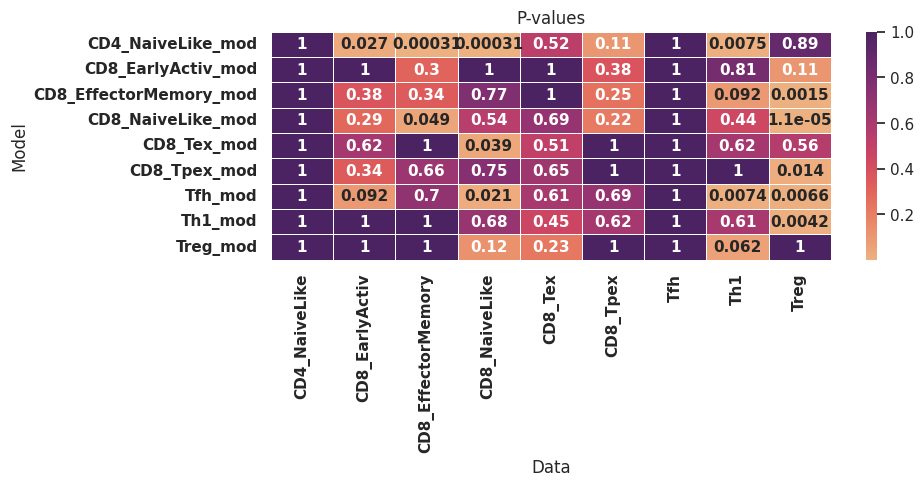

In [313]:
TILonTIL_mtx = p_pivot.astype(float)

###visualize via heatmap
sns.set_theme()
f, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(TILonTIL_mtx, annot=True, annot_kws={'fontsize':11, 'fontweight':'bold'},
            linewidths=.5, ax=ax, cmap='flare')
ax.set_xticklabels(ax.get_xticklabels(), fontweight="bold")
ax.set_yticklabels(ax.get_yticklabels(), fontweight="bold")

ax.set_title('P-values')
plt.savefig('P-vals comparing TIL vs LN subtype model for each subtypde data.pdf',
            format='pdf', dpi=300, bbox_inches='tight')
plt.subplots_adjust(bottom=0.5, left=0.2)
plt.show()

# Heatmap containing auROC values for testing TIL or LN subtype models on TIL T cell types

In [190]:
cols = {'Data':[], 'Model':[], 'Accuracy':[],'auROC':[]}
roc_df = pd.DataFrame(columns = cols)

In [191]:
'''
Use TILglyconorm_sub_df: dictionary containing glyconormed df split by subtype, glycogenes only
Use TILmodel_dict and LNmodel_dict to access the subtype models. they hvae the same keys
Use TILtest_dict to access the test set for each subtype
To extract accuracies and auROCs, use the same test sets for each set of models (so not the full )
'''

test_keys = [i[:-4] for i in list(LNmodel_dict.keys())]

for subtype in test_keys: #for each subtype to test model on. 
        '''extract y and x test sets''' 
        #extract test sets 
        y = str([v for v in TILtest_dict.keys() if v.startswith(subtype) and v.endswith('ytest')][0])
        x = str([v for v in TILtest_dict.keys() if v.startswith(subtype) and v.endswith('xtest')][0])

        y_test = TILtest_dict[y]
        x_test = TILtest_dict[x]
        
        for i in TILmodel_dict.keys(): #each subtype model to test
            TIL_mod = TILmodel_dict[i]
            LN_mod = LNmodel_dict[i]  
       
            # use TIL model to make predictions on the test set
            high, low, total, loss, roc_auc, f1 = model_evaluation(TIL_mod, x_test, y_test)
            TILindex = i+'_TILmod'
            #save TIL model performance in df
            roc_df.loc[len(roc_df)] = [subtype, TILindex, total, roc_auc]

            #use LN model to make predictions on the test set
            high, low, total, loss, roc_auc, f1 = model_evaluation(LN_mod, x_test, y_test)
            LNindex = i +'_LNmod'
            #save TIL model performance in df
            roc_df.loc[len(roc_df)] = [subtype, LNindex, total, roc_auc]

In [197]:
# save pickles!! 
with open('subtype_glycomodels on TILtest.pkl', 'wb') as f:
    pickle.dump(roc_df, f)

In [201]:
#make matrix that contains ROC AUC scores in the table, model on the columns, data on the index
roc_pivot = roc_df.pivot_table(values='auROC', index='Data', columns='Model')
roc_mtx = roc_pivot.astype(float)
roc_pivot
r_piv = roc_mtx.transpose()

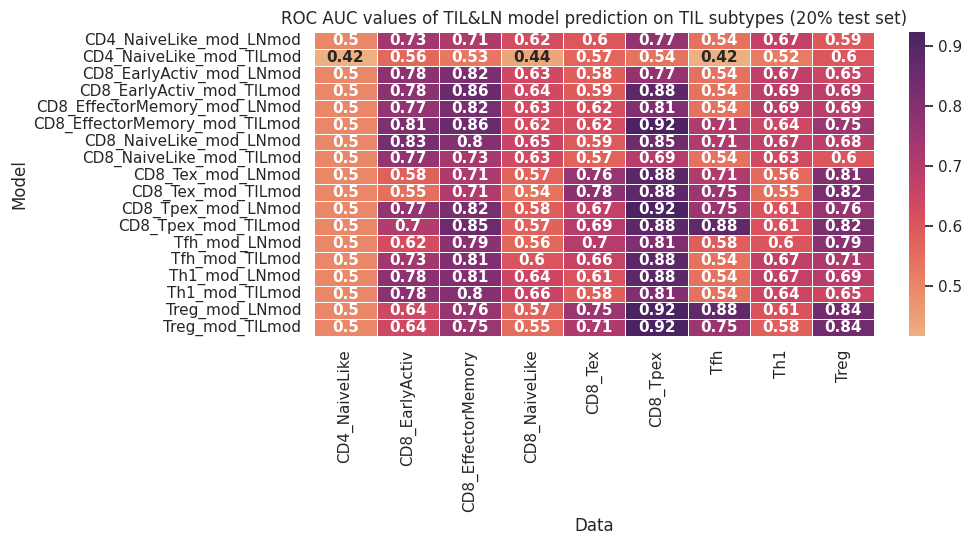

In [213]:
###visualize half via heatmap
sns.set_theme()
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(r_piv, annot=True, annot_kws={'fontsize':11, 'fontweight':'bold'},
            linewidths=.5, ax=ax, cmap='flare')
# ax.set_xticklabels(ax.get_xticklabels(), fontweight="bold")
# ax.set_yticklabels(ax.get_yticklabels(), fontweight="bold")

ax.set_title('ROC AUC values of TIL&LN model prediction on TIL subtypes (20% test set)')
plt.savefig('auROC values of TIL&LN model prediction on TIL subtypes (20% test set).pdf',
            format='pdf', dpi=300, bbox_inches='tight')
plt.subplots_adjust(bottom=0.5, left=0.2)
plt.show()

In [209]:
# make matrix that contains accuracy scores via pivot table. delete all % from string to convert to float
roc_df['Accuracy'] = roc_df['Accuracy'].str.replace('%', '')
acc_pivot = roc_df.pivot_table(values='Accuracy', index='Data', columns='Model')

acc_mtx = acc_pivot.astype(float)
a_piv = acc_mtx.transpose()

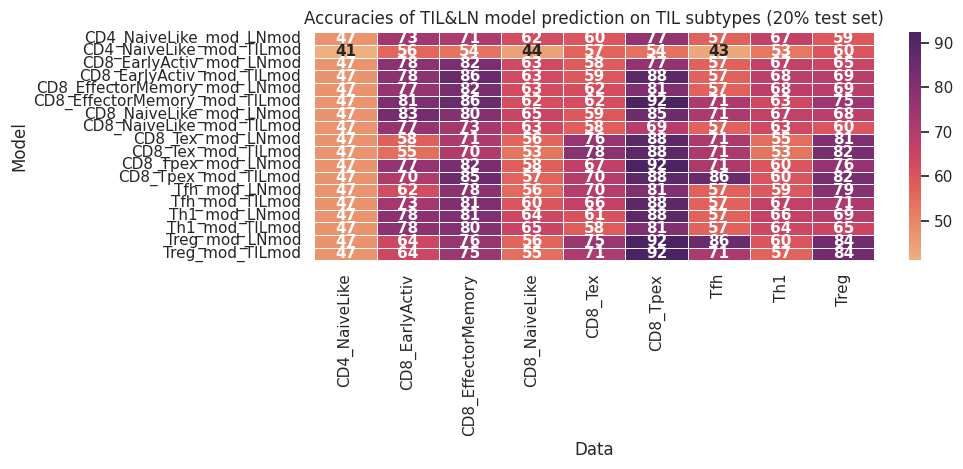

In [211]:
#make matrix that contains ROC AUC scores in the table, model on the columns, data on the index
###visualize half via heatmap
sns.set_theme()
f, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(a_piv, annot=True, annot_kws={'fontsize':11, 'fontweight':'bold'},
            linewidths=.5, ax=ax, cmap='flare')
# ax.set_xticklabels(ax.get_xticklabels(), fontweight="bold")
# ax.set_yticklabels(ax.get_yticklabels(), fontweight="bold")

ax.set_title('Accuracies of TIL&LN model prediction on TIL subtypes (20% test set)')
# plt.savefig('LN model prediction of LN data subtypes heatmap.pdf',format='pdf', dpi=300, bbox_inches='tight')
plt.subplots_adjust(bottom=0.5, left=0.2)
plt.show()

# McNemar test for evaluating prediction of full T cell models from TIL or LN on TIL subtypes 

In [126]:
# pickle in the glycogene all T-cell models 
pickle_in = open("glycoTIL_nohk_model_1.pkl","rb")
glycoTIL_nohk_model_1 = pickle.load(pickle_in)
pickle_in = open("glycoLN_nohk_model_1.pkl","rb")
glycoLN_nohk_model_1 = pickle.load(pickle_in)

In [216]:
# pickle in the dictionary with subtypes split 
pickle_in = open("TILglyconorm_sub_df.pkl","rb")
TILglyconorm_sub_df = pickle.load(pickle_in)

In [219]:
#remove housekeeping 
for name in TILglyconorm_sub_df.keys():
    sub_df = TILglyconorm_sub_df[name]
    #take out housekeeping genes
    housekeeping_list = ['Ahsa1', 'Api5', 'Atp6v1e1', 'Bcap31', 'Cops6', 'Csnk2b', 'Eif3i', 'Eif4g2', 'Gdi2', 
                         'Hnrnpf', 
                         'Hnrnph1', 'Hnrnph2', 'Ilf2', 'Dnajc5', 'Ncl', 'Otub1', 'Pdap1', 'Polr2f', 'Rhoa', 'Srp14', 
                         'Srrm1', 'Timm44', 'Ttc1', 'Ywhab', 'Pdcd6']
    cols_to_remove = sub_df.columns.intersection(housekeeping_list)
    sub_df.drop(columns=cols_to_remove, inplace=True) #now have 216 glycogenes

In [229]:
cols = {'Data':[], 'Contingency table':[], 'McNamar chi squared':[], 'McNamar p-val':[]}
fullglyco_df = pd.DataFrame(columns = cols) #dictionary to store contingency tables for each subtype model

'''
for loop that iterates by subtype data. want to generate dataframe that contains true values, and model 
predictions for each subtype, and add contingency table to cont_df

test dict is TILtest_dict, because want to compare how each subtype model (LN vs TIL) compares in predicting 
each of the different TIL subtype data
'''
#for each subtype to test model on. says model_keys but really is used to access test set 
for subtype in TILglyconorm_sub_df.keys():   
    '''extract subtype dfs and the x and y data to test on '''    
    sub_df = TILglyconorm_sub_df[subtype]
    y = sub_df['PHA-L'].values
    just_genes = sub_df.drop(columns = ['PHA-L', 'Biotin', 'Type'])
    x = just_genes.values

    TIL_pred = glycoTIL_nohk_model_1.predict(x)
    LN_pred = glycoLN_nohk_model_1.predict(x)

    table = mcnemar_table(y_target=y, 
               y_model1=TIL_pred, 
               y_model2=LN_pred)

    t = table.tolist()

    result = mcnemar(t, exact=True)
    chi2 = result.statistic
    p = result.pvalue

    fullglyco_df.loc[len(fullglyco_df)] = [subtype, t, chi2, p]

In [222]:
with open('full_glycomodels on TILsubtypes_mcnemar.pkl', 'wb') as f:
    pickle.dump(fullglyco_df, f)

In [244]:
chi = fullglyco_df[['Data', 'McNamar chi squared']]
pval = fullglyco_df[['Data', 'McNamar p-val']]

In [252]:
#add columm for model for easy pivoting
chi['Model'] = ['full glyco model' for i in np.arange(len(chi))]
pval['Model'] = ['full glyco model' for i in np.arange(len(pval))]

chi_pivot = chi.pivot_table(values='McNamar chi squared', index='Model', columns='Data')
pval_pivot = pval.pivot_table(values='McNamar p-val', index='Model', columns='Data')

chi_mtx = chi_pivot.astype(float)
pval_mtx = pval_pivot.astype(float)

/tmp/ipykernel_4303/569809942.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chi['Model'] = ['full glyco model' for i in np.arange(len(chi))]
/tmp/ipykernel_4303/569809942.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pval['Model'] = ['full glyco model' for i in np.arange(len(pval))]


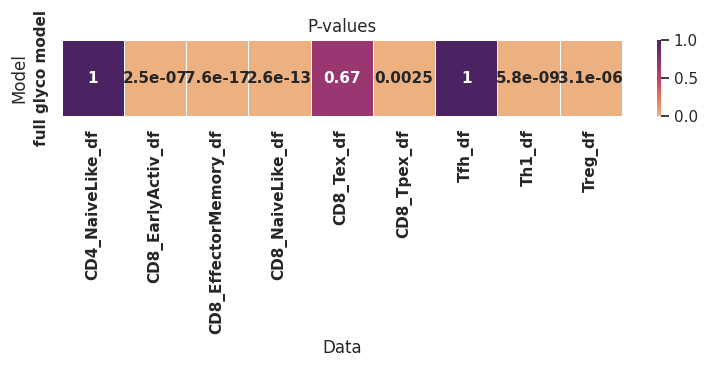

In [296]:
###visualize via heatmap
sns.set_theme()
f, ax = plt.subplots(figsize=(10, 2))
sns.heatmap(pval_mtx, annot=True, annot_kws={'fontsize':11, 'fontweight':'bold'},
            linewidths=.5, ax=ax, cmap='flare')
ax.set_xticklabels(ax.get_xticklabels(), fontweight="bold")
ax.set_yticklabels(ax.get_yticklabels(), fontweight="bold")

ax.set_title('P-values')
plt.savefig('P-vals comparing full TIL and LN glycomodels against TIL subtypes.pdf',
            format='pdf', dpi=300, bbox_inches='tight')
plt.subplots_adjust(bottom=0.5, left=0.2)
plt.show()

## auROC heatmaps for full T cell glycogene models (TIL/LN) on the T cell subtypes from TIL

In [285]:
cols = {'Data':[], 'Model':[], 'Accuracy':[],'auROC':[]}
glycoroc_df = pd.DataFrame(columns = cols)

In [286]:
'''
Use TILglyconorm_sub_df: dictionary containing glyconormed df split by subtype, glycogenes only
Use TILmodel_dict and LNmodel_dict to access the subtype models. they hvae the same keys
Use TILtest_dict to access the test set for each subtype
To extract accuracies and auROCs, use the same test sets for each set of models (so not the full )
'''
for subtype in TILglyconorm_sub_df.keys():   
    '''extract subtype dfs and the x and y data to test on '''    
    sub_df = TILglyconorm_sub_df[subtype]
    y = sub_df['PHA-L'].values
    just_genes = sub_df.drop(columns = ['PHA-L', 'Biotin', 'Type'])
    x = just_genes.values
    
    #use TIL model to make predictions on the test set
    high, low, total, loss, roc_auc, f1 = model_evaluation(glycoTIL_nohk_model_1, x, y)
    #save TIL model performance in df
    glycoroc_df.loc[len(glycoroc_df)] = [subtype, 'full glycoTIL', total, roc_auc]

    #use LN model to make predictions on the test set
    high, low, total, loss, roc_auc, f1 = model_evaluation(glycoLN_nohk_model_1, x, y)
    #save TIL model performance in df
    glycoroc_df.loc[len(glycoroc_df)] = [subtype, 'full glycoLN', total, roc_auc]

In [288]:
# save pickles!! 
with open('full_glycomodels on TILtest.pkl', 'wb') as f:
    pickle.dump(glycoroc_df, f) 

In [289]:
#make matrix that contains ROC AUC scores in the table, model on the columns, data on the index
glycoroc_pivot = glycoroc_df.pivot_table(values='auROC', index='Data', columns='Model')
glycoroc_mtx = glycoroc_pivot.astype(float)
g_piv = glycoroc_mtx.transpose()

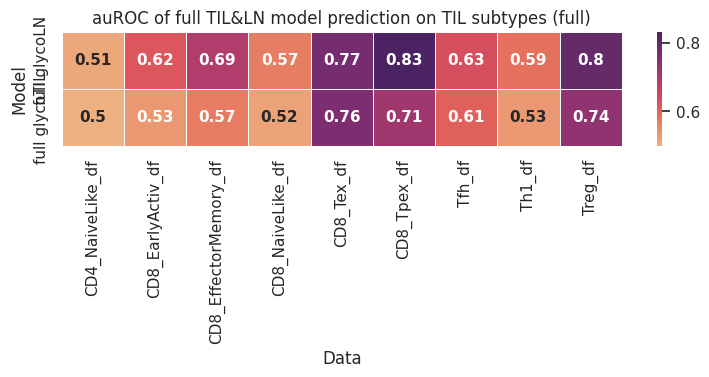

In [306]:
#make matrix that contains ROC AUC scores in the table, model on the columns, data on the index
###visualize half via heatmap
sns.set_theme()
f, ax = plt.subplots(figsize=(10, 3))
sns.heatmap(g_piv, annot=True, annot_kws={'fontsize':11, 'fontweight':'bold'},
            linewidths=.5, ax=ax, cmap='flare')
# ax.set_xticklabels(ax.get_xticklabels(), fontweight="bold")
# ax.set_yticklabels(ax.get_yticklabels(), fontweight="bold")

ax.set_title('auROC of full TIL&LN model prediction on TIL subtypes (full)')
plt.savefig('TIL&LN glycomodel prediction on  TIL data subtypes heatmap.pdf',format='pdf', 
            dpi=300, bbox_inches='tight')
plt.subplots_adjust(bottom=0.5, left=0.2)
plt.show()